# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 74090.88 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 100992.31 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 120231.47 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 132091.36 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 139893.77 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 146169.56 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 74257.94 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105090.47 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 129078.52 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 140695.41 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 146847.16 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151248.27 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.95 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.93 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.08 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.13 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.07 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.99 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.55 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.90 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.93 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.75 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.08 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.62 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.81 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.74 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.17 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.65 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.15 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.35 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.48 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.64 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.79 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.77 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.61 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 34.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.52 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.76 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.35 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.62 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.64 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.21 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.78 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.32 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.33 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.56 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.48 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.49 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.47 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.28 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.11 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.86 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.58 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.58 examples/s]

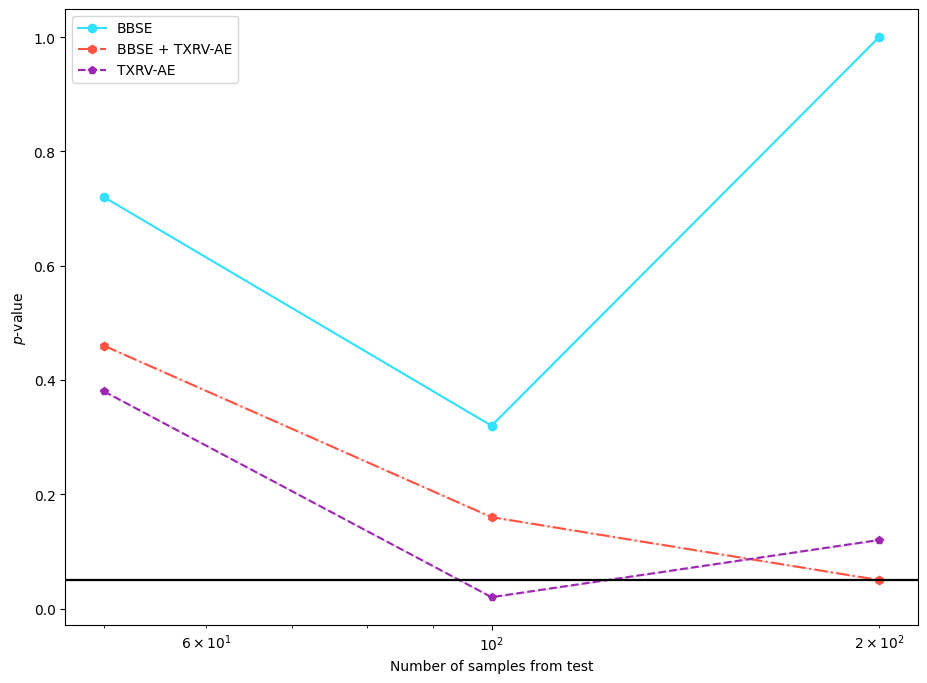

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.71 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.81 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.55 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.88 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.71 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.28 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.57 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.17 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.14 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.13 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.54 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.09 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.07 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.13 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.03 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.74 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.17 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.48 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.57 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.60 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.32 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.73 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.21 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.86 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.87 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.52 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.07 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.58 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.57 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.92 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.71 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.63 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.74 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.04 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.91 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.12 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.22 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.00 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.42 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.94 examples/s]

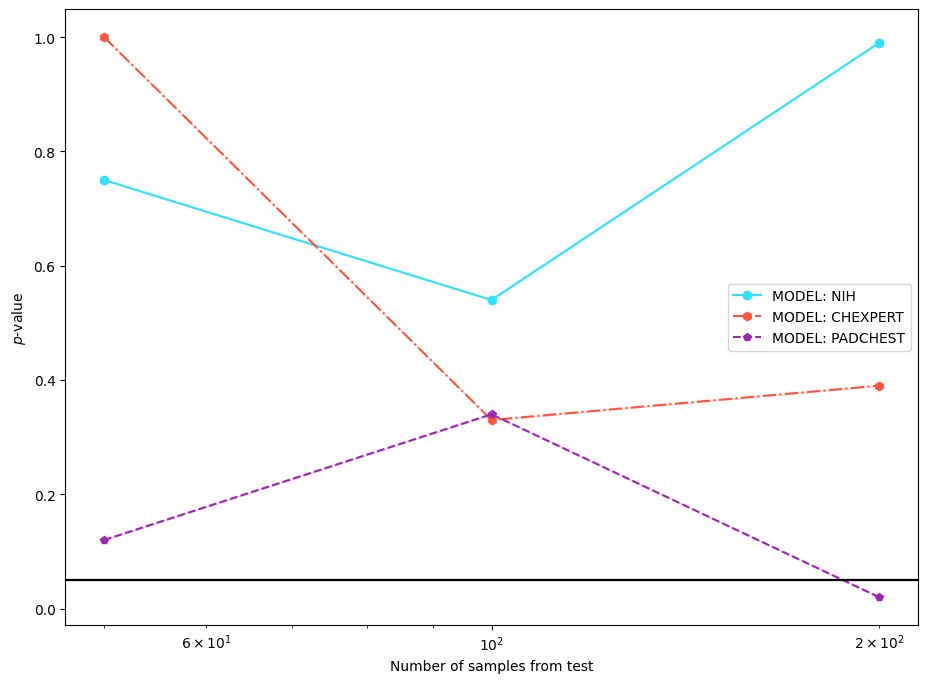

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57911.52 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 83888.39 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 98326.04 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104779.93 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 109422.03 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113780.13 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55057.91 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81118.96 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95695.01 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 107421.76 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 112251.80 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 115232.45 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.40 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.15 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.54 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.43 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.61 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.42 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.54 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.32 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.04 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.92 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.44 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.18 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.22 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.31 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.59 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51346.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72971.18 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87942.12 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97837.17 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 105214.56 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110050.76 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56479.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81601.93 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94367.72 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102720.24 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107944.26 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112036.10 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.55 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.38 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.27 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.55 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.86 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.03 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.22 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.82 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.61 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.66 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.92 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.86 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.15 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.51 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54435.47 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76380.32 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87949.13 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92516.19 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99442.06 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103301.82 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48605.09 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70207.95 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85666.75 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100347.72 examples/s]

Filter (num_proc=6):  82%|████████▏ | 91748/112120 [00:01<00:00, 95542.94 examples/s] 

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113037.33 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.48 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.83 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.54 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.13 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.39 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.14 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.03 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.62 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.86 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.15 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.95 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.90 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.16 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.41 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.13 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59433.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82224.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95898.96 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103758.30 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108289.35 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112897.76 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53313.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78215.70 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92136.05 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101143.81 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107081.30 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111649.10 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.61 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.59 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.78 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.23 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.69 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.55 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.97 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.53 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.51 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.41 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.31 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.41 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.60 examples/s]

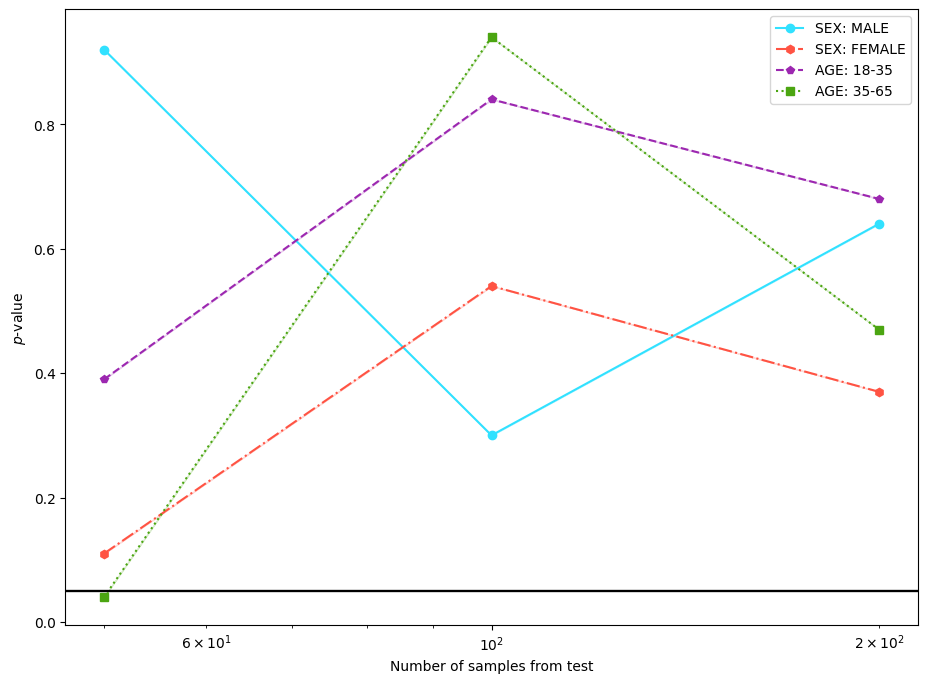

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.54 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.22 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.10 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.05 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.81 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.11 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.79 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.16 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.24 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.18 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.31 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.41 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.14 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.68 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.13 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.13 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.26 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.04 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.18 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.31 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.63 examples/s]

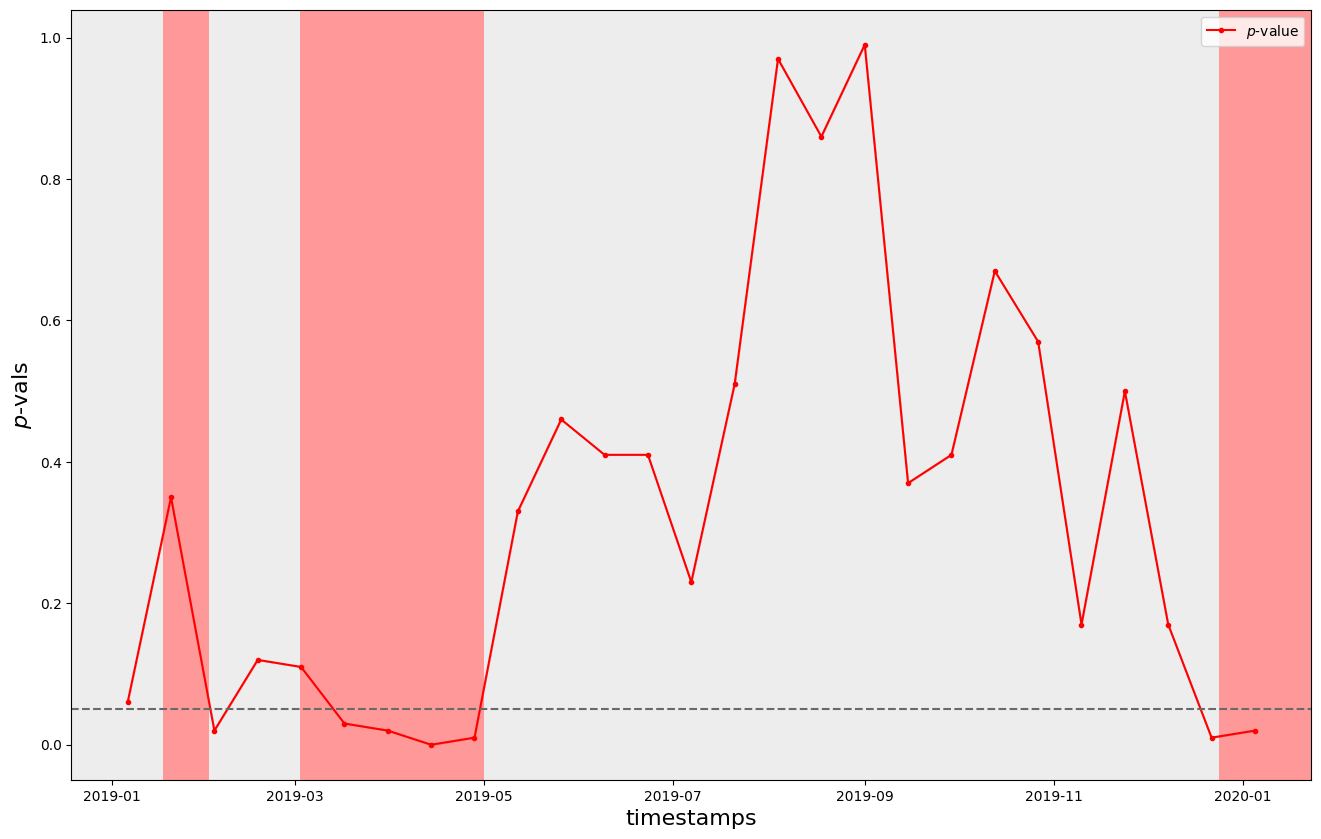

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)